In [ ]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy import sparse
from dataclasses import dataclass
import numpy as np
import pickle
import os
import time

In [270]:
@dataclass
class DatasetDivision:
    dataset_name: str
    df_train: pd.DataFrame
    X_train: pd.DataFrame
    X_test: pd.DataFrame
    df_test_unseen: pd.DataFrame

    def save_to_pickle(self, base_dir="."):
        os.makedirs(base_dir, exist_ok=True)
        path = os.path.join(base_dir, f"{self.dataset_name}_tts.pkl")
        with open(path, "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load_from_pickle(cls, dataset_name, base_dir="."):
        path = os.path.join(base_dir, f"{dataset_name}_tts.pkl")
        with open(path, "rb") as f:
            return pickle.load(f)


In [298]:
def divide_dataset(df: pd.DataFrame, dataset_name: str):
    df["item_id"], unique_item_ids = pd.factorize(df["item_id"])
    n_items = len(unique_item_ids)

    # Train Test Split
    print("Performing TTS")
    gss = GroupShuffleSplit(n_splits = 1, train_size=0.75, random_state=12)
    groups = gss.split(df, groups=df["user_id"])
    train_indices = []
    test_indices = []
    for fold_train_indices, fold_test_indices in groups:
        train_indices = fold_train_indices
        test_indices = fold_test_indices
    df_train = df.iloc[train_indices].copy()
    df_test = df.iloc[test_indices].copy()

    # Sparsify Train
    df_train["user_id"], unique_train_user_ids = pd.factorize(df_train["user_id"])
    n_training_users = len(unique_train_user_ids)
    X_train = sparse.csr_matrix(
        (df_train["rating"], (df_train["user_id"], df_train["item_id"])),
        shape=(n_training_users, n_items)
    )

    # Seen Unseen Split
    df_test["user_id"], unique_test_user_ids = pd.factorize(df_test["user_id"])
    n_testing_users = len(unique_test_user_ids)
    user_rating_counts = df_test.groupby("user_id")["rating"].count()
    users_with_one_rating = user_rating_counts[user_rating_counts == 1].index
    df_test = df_test[~df_test["user_id"].isin(users_with_one_rating)]
    df_test_unseen, df_test_seen = train_test_split(df_test, test_size=0.5, stratify=df_test["user_id"])

    # Sparsify Seen
    X_test = sparse.csr_matrix(
        (df_test_seen["rating"], (df_test_seen["user_id"], df_test_seen["item_id"])),
        shape=(n_testing_users, n_items)
    )

    dataset_division = DatasetDivision(
        dataset_name=dataset_name,
        df_train=df_train,
        X_train=X_train,
        X_test=X_test,
        df_test_unseen=df_test_unseen
    )
    dataset_division.save_to_pickle()
    return dataset_division

In [309]:
def evaluate_dataset(datasets: pd.DataFrame, k_values: list[int]):
    dataset_name = datasets.dataset_name
    df_train = datasets.df_train
    X_train = datasets.X_train
    X_test = datasets.X_test
    df_test_unseen = datasets.df_test_unseen

    model = NearestNeighbors(n_neighbors=k_values[-1], metric="cosine", n_jobs=8)

    print("Fitting Nearest Neighbors Model...")
    model.fit(X_train)

    # Find Neighbors
    print("Finding Neighbors...")
    start_neighbors_time = time.perf_counter()
    distances, nearest_neighbors = model.kneighbors(X_test)
    neighbor_time = time.perf_counter() - start_neighbors_time
    print(f"Time to find neighbors: {neighbor_time:.2f} seconds")

    # Save neighbors
    np.save(f"{dataset_name}_nearest_neighbors", (distances, nearest_neighbors))

    # Prepare rating lookup
    df_train_indexed = df_train.set_index(["user_id", "item_id"]).sort_index()
    rating_lookup = df_train_indexed["rating"].to_dict()

    def calculate_average_rating(row, k):
        user_ids = nearest_neighbors[int(row["user_id"])][:k]
        item_id = row["item_id"]
        ratings = [
            rating_lookup.get((user_id, item_id))
            for user_id in user_ids
            if (user_id, item_id) in rating_lookup
        ]
        return np.mean(ratings) if ratings else np.nan

    # Predict ratings for each k
    for k in k_values:
        print(f"\nCalculating Average Ratings for k = {k}...")
        start_k_time = time.perf_counter()

        df_test_unseen[f"predicted_rating_k{k}"] = df_test_unseen.apply(
            lambda row: calculate_average_rating(row, k=k), axis=1
        )

        duration = time.perf_counter() - start_k_time
        print(f"Time for k = {k}: {duration:.2f} seconds")

        df_test_unseen.to_feather(f"{dataset_name}_predictions_2.feather")

    print(f"\n{dataset_name} Coefficients of Determination")
    for k in k_values:
        valid = df_test_unseen[~df_test_unseen[f"predicted_rating_k{k}"].isna()]
        if not valid.empty:
            stats = linregress(valid["rating"], valid[f"predicted_rating_k{k}"])
            print(f"K = {k}: R² = {stats.rvalue ** 2:.4f}  (n = {len(valid)})")
        else:
            print(f"K = {k}: No valid predictions")


In [352]:
base_k_values = [5, 10, 25, 50, 100, 150, 250, 350, 500]

In [ ]:
movie_df = pd.read_feather("../../Data/movielens_25m.feather")
movielens_split = divide_dataset(movie_df, "movielens")
evaluate_dataset(movielens_split, base_k_values)

Fitting Nearest Neighbors Model...
Finding Neighbors...
Time to find neighbors: 314.22 seconds

Calculating Average Ratings for k = 5...
Time for k = 5: 49.75 seconds

Calculating Average Ratings for k = 10...
Time for k = 10: 60.33 seconds

Calculating Average Ratings for k = 25...
Time for k = 25: 101.10 seconds

Calculating Average Ratings for k = 50...
Time for k = 50: 188.86 seconds

Calculating Average Ratings for k = 100...
Time for k = 100: 303.01 seconds

Calculating Average Ratings for k = 150...
Time for k = 150: 421.30 seconds

Calculating Average Ratings for k = 250...
Time for k = 250: 666.22 seconds

Calculating Average Ratings for k = 350...
Time for k = 350: 921.09 seconds

Calculating Average Ratings for k = 500...
Time for k = 500: 1266.34 seconds

movielens Coefficients of Determination
K = 5: R² = 0.1416  (n = 2211405)
K = 10: R² = 0.1608  (n = 2486014)
K = 25: R² = 0.1864  (n = 2740005)
K = 50: R² = 0.2027  (n = 2867804)
K = 100: R² = 0.2171  (n = 2954652)
K = 150

In [ ]:
bgg_df = pd.read_feather("../../Data/boardgamegeek.feather")
bgg_df = bgg_df[~bgg_df["user_id"].isnull()]
bgg_split = divide_dataset(bgg_df, "boardgamegeek")
evaluate_dataset(bgg_split, base_k_values)

Performing TTS
Fitting Nearest Neighbors Model...
Finding Neighbors...
Time to find neighbors: 986.35 seconds

Calculating Average Ratings for k = 5...
Time for k = 5: 32.06 seconds

Calculating Average Ratings for k = 10...
Time for k = 10: 35.85 seconds

Calculating Average Ratings for k = 25...
Time for k = 25: 52.94 seconds

Calculating Average Ratings for k = 50...
Time for k = 50: 78.30 seconds

Calculating Average Ratings for k = 100...
Time for k = 100: 132.15 seconds

Calculating Average Ratings for k = 150...
Time for k = 150: 209.00 seconds

Calculating Average Ratings for k = 250...
Time for k = 250: 344.53 seconds

Calculating Average Ratings for k = 350...
Time for k = 350: 440.43 seconds

Calculating Average Ratings for k = 500...
Time for k = 500: 629.91 seconds

boardgamegeek Coefficients of Determination
K = 5: R² = 0.1576  (n = 938703)
K = 10: R² = 0.1710  (n = 1137166)
K = 25: R² = 0.1916  (n = 1393493)
K = 50: R² = 0.2073  (n = 1576223)
K = 100: R² = 0.2231  (n = 1

In [ ]:
yahoo_df = pd.read_feather("../../Data/yahoo_r2_songs.subsampled.feather")
yahoo_df = yahoo_df[~yahoo_df["user_id"].isnull()]
yahooo_split = divide_dataset(yahoo_df, "yahoo_songs")
evaluate_dataset(yahooo_split, base_k_values)

Performing TTS
Fitting Nearest Neighbors Model...
Finding Neighbors...
Time to find neighbors: 4887.95 seconds

Calculating Average Ratings for k = 5...
Time for k = 5: 8.98 seconds

Calculating Average Ratings for k = 10...
Time for k = 10: 10.33 seconds

Calculating Average Ratings for k = 25...
Time for k = 25: 15.33 seconds

Calculating Average Ratings for k = 50...
Time for k = 50: 26.08 seconds

Calculating Average Ratings for k = 100...
Time for k = 100: 40.79 seconds

Calculating Average Ratings for k = 150...
Time for k = 150: 51.13 seconds

Calculating Average Ratings for k = 250...
Time for k = 250: 72.85 seconds

Calculating Average Ratings for k = 350...
Time for k = 350: 97.92 seconds

Calculating Average Ratings for k = 500...
Time for k = 500: 151.28 seconds

yahoo_songs Coefficients of Determination
K = 5: R² = 0.0638  (n = 34226)
K = 10: R² = 0.0587  (n = 56604)
K = 25: R² = 0.0564  (n = 105045)
K = 50: R² = 0.0566  (n = 158634)
K = 100: R² = 0.0605  (n = 229181)
K = 

In [ ]:
np_df = pd.read_feather("../../Data/netflix_prize.feather")
np_df = np_df[~np_df["user_id"].isnull()]
np_split = divide_dataset(np_df, "netflix_prize")
evaluate_dataset(np_split, base_k_values)

Performing TTS
Fitting Nearest Neighbors Model...
Finding Neighbors...
Time to find neighbors: 2637.31 seconds

Calculating Average Ratings for k = 5...
Time for k = 5: 79.07 seconds

Calculating Average Ratings for k = 10...
Time for k = 10: 100.58 seconds

Calculating Average Ratings for k = 25...
Time for k = 25: 182.20 seconds

Calculating Average Ratings for k = 50...
Time for k = 50: 322.25 seconds

Calculating Average Ratings for k = 100...
Time for k = 100: 514.53 seconds

Calculating Average Ratings for k = 150...
Time for k = 150: 739.29 seconds

Calculating Average Ratings for k = 250...
Time for k = 250: 1192.82 seconds

Calculating Average Ratings for k = 350...
Time for k = 350: 1635.21 seconds

Calculating Average Ratings for k = 500...
Time for k = 500: 2298.66 seconds

netflix_prize Coefficients of Determination
K = 5: R² = 0.1085  (n = 4167252)
K = 10: R² = 0.1282  (n = 4754818)
K = 25: R² = 0.1527  (n = 5325049)
K = 50: R² = 0.1691  (n = 5640079)
K = 100: R² = 0.1829

In [310]:
evaluate_dataset(movielens_split, [1000])

Fitting Nearest Neighbors Model...
Finding Neighbors...
Time to find neighbors: 147.97 seconds

Calculating Average Ratings for k = 1000...
Time for k = 1000: 2382.11 seconds

movielens Coefficients of Determination
K = 1000: R² = 0.2367  (n = 3070901)


In [311]:
def sparse_matrix_to_df(sparse_matrix: sparse.csr_matrix) -> pd.DataFrame:
    coo = sparse_matrix.tocoo()
    return pd.DataFrame({
        "user_id": coo.row,
        "item_id": coo.col,
        "rating": coo.data
    })

def print_sizes(dataset: DatasetDivision):
    def describe(df: pd.DataFrame, name: str):
        num_ratings = len(df)
        num_users = df["user_id"].nunique()
        num_items = df["item_id"].nunique()
        print(f"{name} set:")
        print(f"  Number of ratings: {num_ratings}")
        print(f"  Number of unique users: {num_users}")
        print(f"  Number of unique items: {num_items}")
        print()

    print(f"Dataset: {dataset.dataset_name}\n")
    describe(dataset.df_train, "Training")
    describe(sparse_matrix_to_df(dataset.X_test), "Seen Testing")
    describe(dataset.df_test_unseen, "Unseen Testing")


In [312]:
print_sizes(movielens_split)

Dataset: movielens

Training set:
  Number of ratings: 18714181
  Number of unique users: 121905
  Number of unique items: 24330

Seen Testing set:
  Number of ratings: 3088201
  Number of unique users: 40636
  Number of unique items: 22832

Unseen Testing set:
  Number of ratings: 3088201
  Number of unique users: 40636
  Number of unique items: 22828



In [313]:
print_sizes(bgg_split)

Dataset: boardgamegeek

Training set:
  Number of ratings: 14199311
  Number of unique users: 308530
  Number of unique items: 21925

Seen Testing set:
  Number of ratings: 2359483
  Number of unique users: 83092
  Number of unique items: 21889

Unseen Testing set:
  Number of ratings: 2361544
  Number of unique users: 83092
  Number of unique items: 21896



In [426]:
print_sizes(yahooo_split)

Dataset: yahoo_songs

Training set:
  Number of ratings: 5209583
  Number of unique users: 941446
  Number of unique items: 1368

Seen Testing set:
  Number of ratings: 813282
  Number of unique users: 212687
  Number of unique items: 1368

Unseen Testing set:
  Number of ratings: 813281
  Number of unique users: 212687
  Number of unique items: 1368



In [315]:
print_sizes(np_split)

Dataset: netflix_prize

Training set:
  Number of ratings: 38275663
  Number of unique users: 358513
  Number of unique items: 9210

Seen Testing set:
  Number of ratings: 6377320
  Number of unique users: 118453
  Number of unique items: 9206

Unseen Testing set:
  Number of ratings: 6377320
  Number of unique users: 118453
  Number of unique items: 9209



In [424]:
def plot_rating_count_hists(datasets: list[DatasetDivision], k_values: list[int]):
    num_datasets = len(datasets)
    num_k = len(k_values)
    total_rows = num_k + 1  # one extra row for k=∞

    fig, axes = plt.subplots(
        total_rows, num_datasets, figsize=(5 * num_datasets, 4 * total_rows),
        sharex='col', sharey='col'
    )
    fig.suptitle("Prediction Counts By User", fontsize=18)

    if num_datasets == 1:
        axes = np.expand_dims(axes, axis=1)
    if total_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for col_idx, dataset in enumerate(datasets):
        df = dataset.df_test_unseen
        dataset_name = dataset.dataset_name

        for row_idx, k in enumerate(k_values):
            ax = axes[row_idx, col_idx]
            col = f"predicted_rating_k{k}"

            if col not in df.columns:
                ax.set_visible(False)
                continue

            all_user_ids = df["user_id"].unique()
            user_id_counts = df.groupby("user_id")[col].agg('count')
            user_id_counts = pd.Series(user_id_counts, index=all_user_ids).fillna(0).astype(int)

            sns.histplot(user_id_counts, bins=15, log_scale=True, ax=ax)

            if row_idx == 0:
                ax.set_title(dataset_name, fontsize=14)

            if col_idx == 0:
                ax.set_ylabel(f"k={k}\nUser Count\n(Log Scale)", fontsize=11)
            else:
                ax.set_ylabel("")

            ax.set_xlabel("")
            ax.tick_params(axis='both', labelsize=10)

        # Final row: non-personalized (k=∞)
        ax = axes[num_k, col_idx]
        user_id_counts = df.groupby("user_id")["item_id"].count()
        sns.histplot(user_id_counts, bins=15, log_scale=True, ax=ax, color="red")

        if col_idx == 0:
            ax.set_ylabel("k=∞\nUser Count\n(Log Scale)", fontsize=11)
        else:
            ax.set_ylabel("")

        ax.set_xlabel("Number of Predictions", fontsize=12)
        ax.tick_params(axis='both', labelsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # leaves space for suptitle
    plt.show()


In [438]:
movielens_split.dataset_name = "Movie Lens"
bgg_split.dataset_name = "Board Game Geek"
yahooo_split.dataset_name = "Yahoo! Music"
np_split.dataset_name = "Netflix Prize"

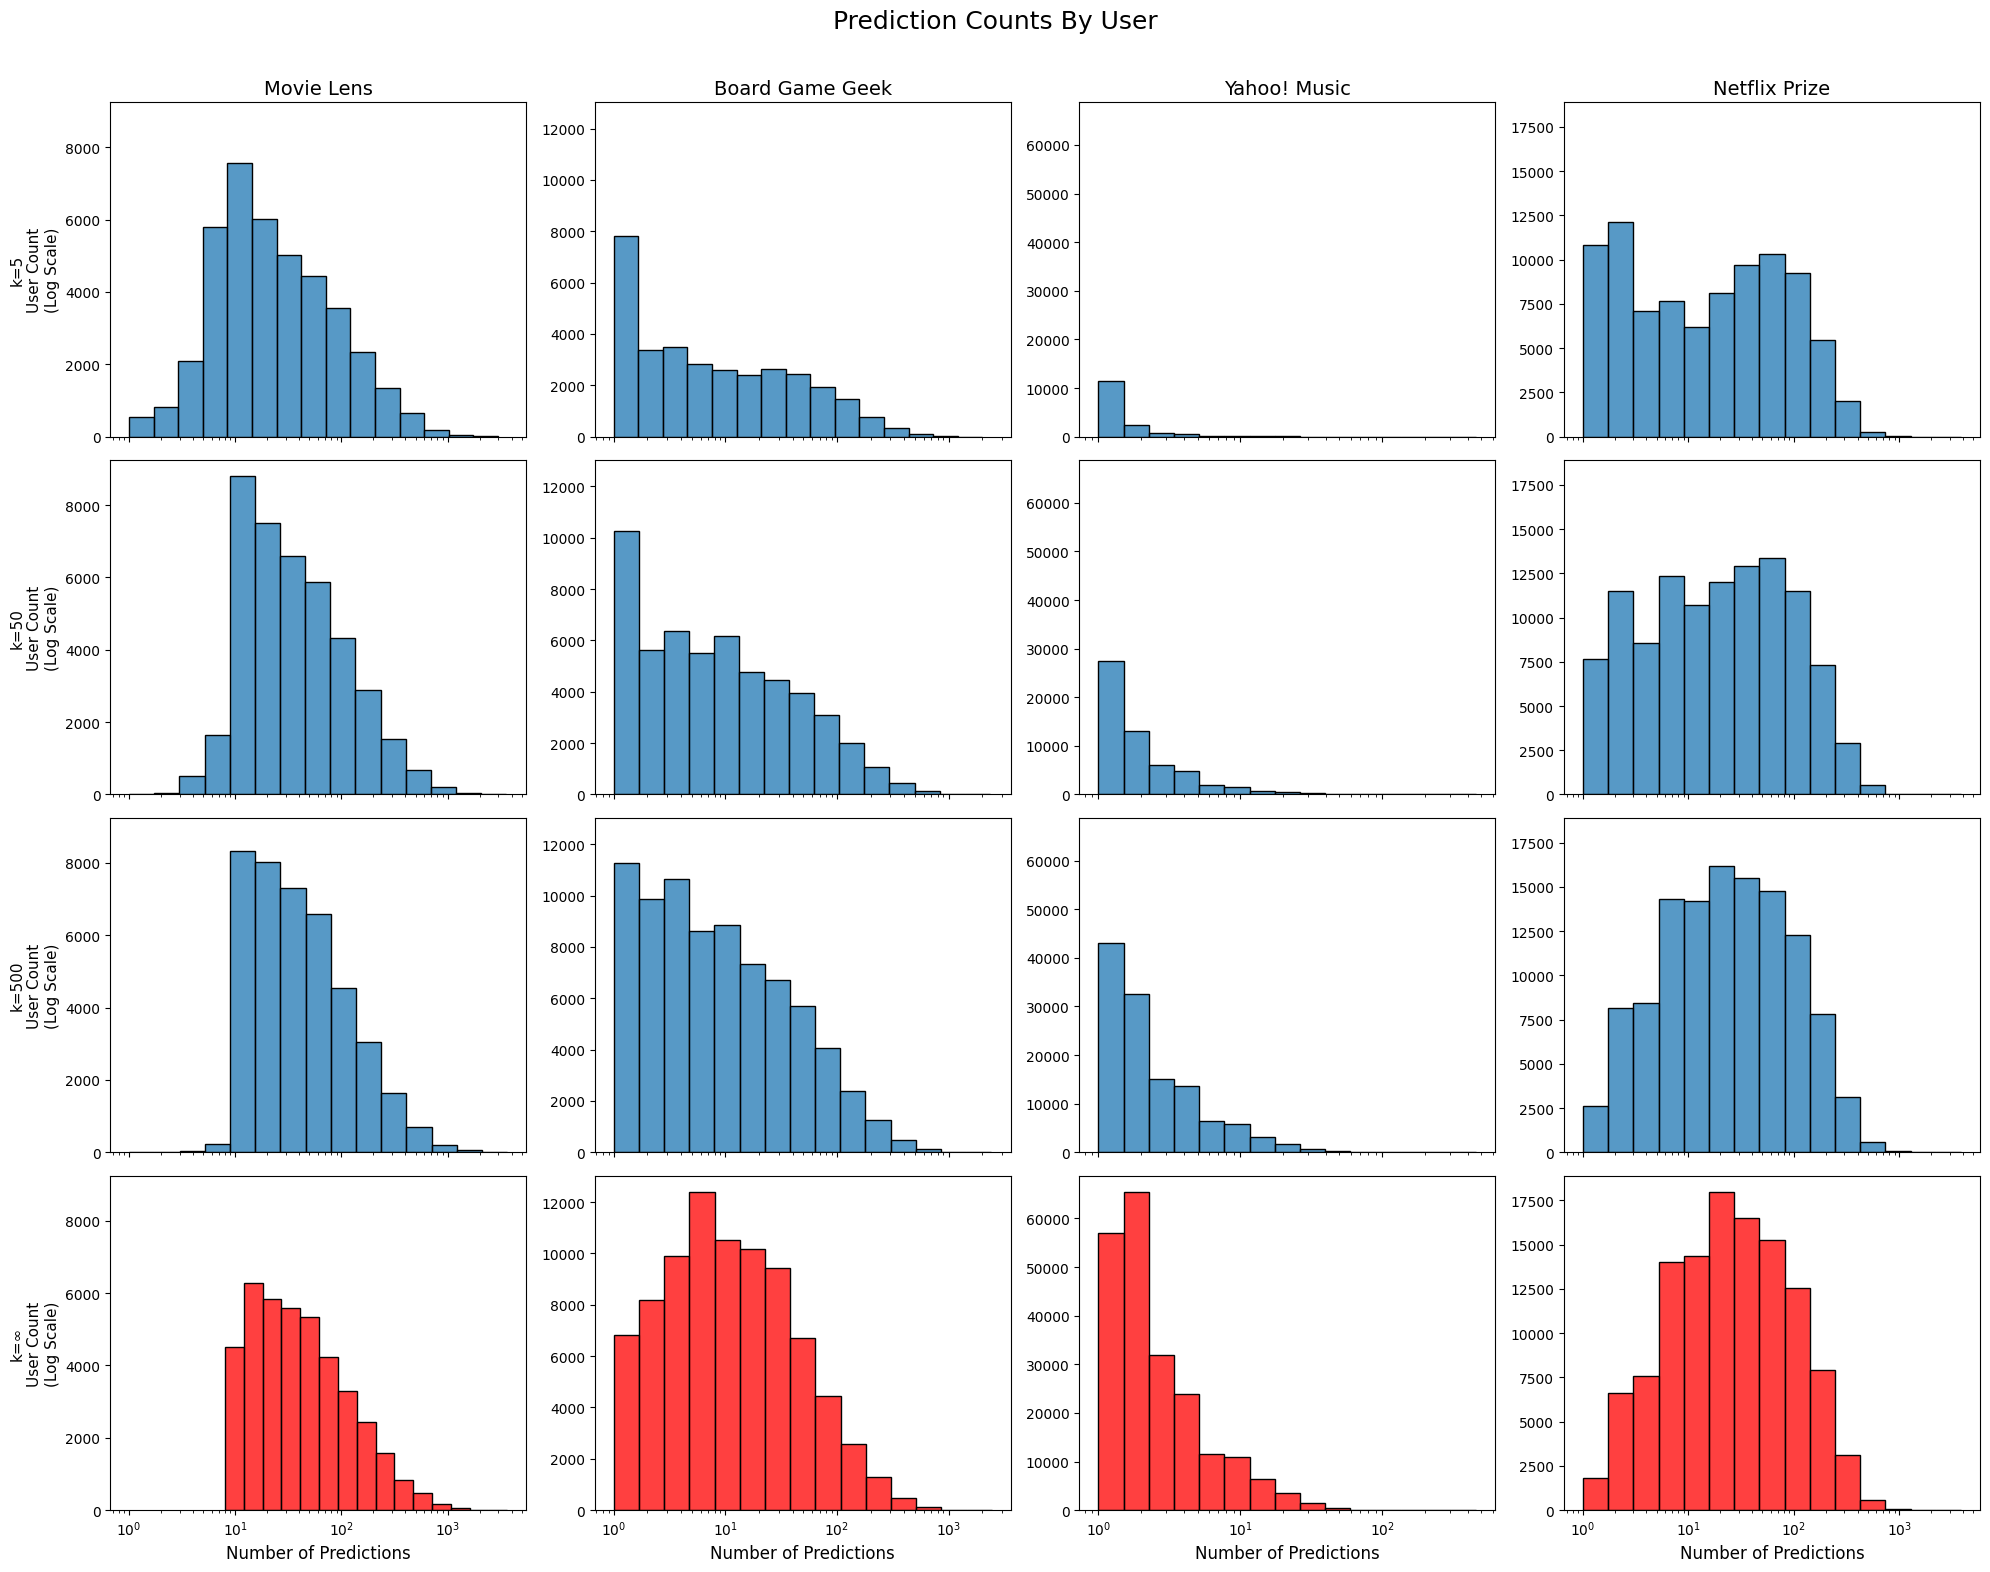

In [441]:
plot_rating_count_hists([movielens_split, bgg_split, yahooo_split, np_split], [5, 50, 500])

In [434]:
yahooo_split.df_test_unseen

,user_id,item_id,rating,predicted_rating_k5,predicted_rating_k10,predicted_rating_k25,predicted_rating_k50,predicted_rating_k100,predicted_rating_k150,predicted_rating_k250,predicted_rating_k350,predicted_rating_k500
10194195,150998,166,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,3.333333
64024277,75068,168,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56068195,236762,105,1,NaN,NaN,NaN,1.666667,1.400000,1.4,1.4,1.400000,1.400000
55077017,136965,816,4,NaN,NaN,2.0,1.500000,1.333333,1.4,1.5,1.500000,2.000000
29419777,226230,1074,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
73397525,213441,10,3,NaN,NaN,NaN,NaN,NaN,NaN,3.5,3.666667,2.875000
26931035,23727,245,4,NaN,NaN,NaN,NaN,4.000000,4.0,4.0,4.000000,4.000000
28130564,59676,777,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49831844,179982,50,4,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.000000,4.000000


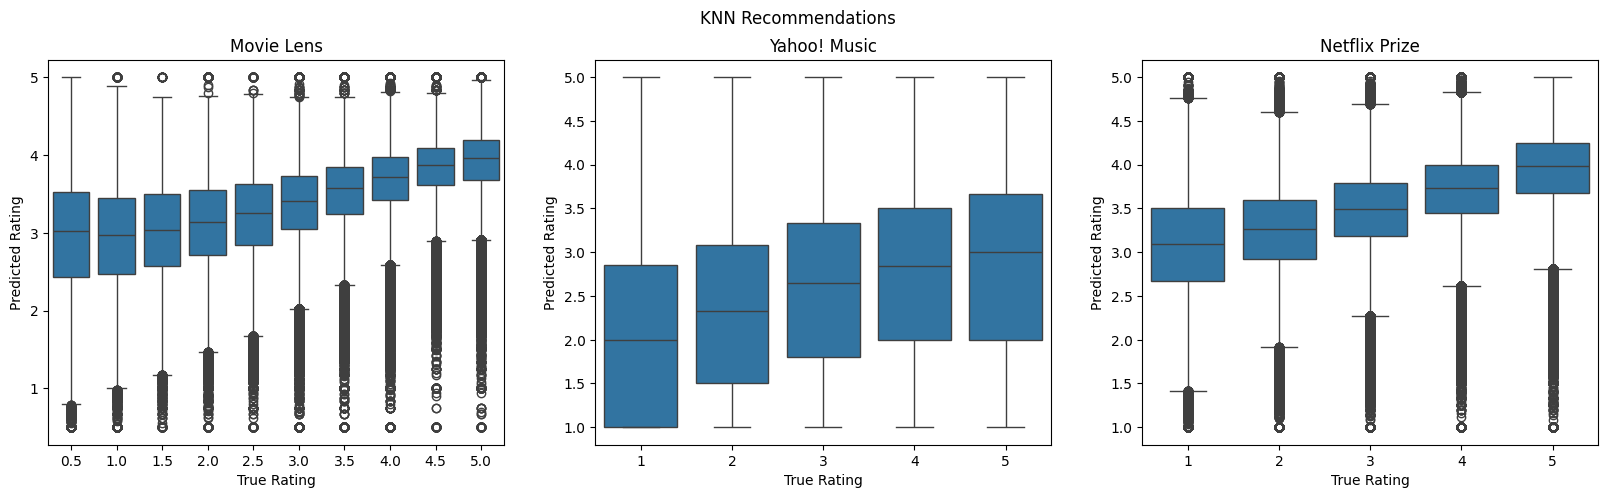

In [437]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
fig.suptitle("KNN Recommendations")
movielens_ax: plt.Axes = axes[0]
yahoo_ax: plt.Axes = axes[1]
np_ax: plt.Axes = axes[2]

sns.boxplot(movielens_split.df_test_unseen[~movielens_split.df_test_unseen["predicted_rating_k500"].isna()], x="rating", y="predicted_rating_k500", ax=movielens_ax)
movielens_ax.set_xlabel("True Rating")
movielens_ax.set_ylabel("Predicted Rating")
movielens_ax.set_title("Movie Lens")

sns.boxplot(yahooo_split.df_test_unseen[~yahooo_split.df_test_unseen["predicted_rating_k500"].isna()], x="rating", y="predicted_rating_k500", ax=yahoo_ax)
yahoo_ax.set_xlabel("True Rating")
yahoo_ax.set_ylabel("Predicted Rating")
yahoo_ax.set_title("Yahoo! Music")

sns.boxplot(np_split.df_test_unseen[~np_split.df_test_unseen["predicted_rating_k500"].isna()], x="rating", y="predicted_rating_k500", ax=np_ax)
np_ax.set_xlabel("True Rating")
np_ax.set_ylabel("Predicted Rating")
np_ax.set_title("Netflix Prize")

plt.show()

In [ ]:
# def slow_rating_calculation(row):
#     average_rating = df_train[
#         df_train["user_id"].isin(nearest_neighbors[int(row["user_id"])]) &
#         (df_train["item_id"] == row["item_id"])
#     ]["rating"].mean()
#     return average_rating

In [ ]:
# def faster_rating_calculation(row):
#     user_ids = nearest_neighbors[int(row["user_id"])]
#     item_id = row["item_id"]
#     ratings = []
    
#     for user_id in user_ids:
#         try:
#             rating = df_train_indexed.loc[(user_id, item_id), "rating"]
#             ratings.append(rating)
#         except Exception:
#             continue  # No rating from this neighbor for this item
    
#     if ratings:
#         return np.mean(ratings)
#     else:
#         return np.nan  # or some default value, e.g., global average